In [21]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import find_peaks
import scipy.io as sio
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]


sys.path.append("gpib_instrument_control/")
import lmx2594cmd
import gpib_instrument_control.hp_8569b
import gpib_instrument_control.hp_5340a
import gpib_instrument_control.pm_1038
import gpib_instrument_control.hp_3478a
import gpib_instrument_control.wiltron_6659a


sp = gpib_instrument_control.hp_8569b.Hp8569B()
counter=gpib_instrument_control.hp_5340a.Hp5340A()
powBMeter=gpib_instrument_control.hp_3478a.Hp3478A()
pm=gpib_instrument_control.pm_1038.Pm1038(None, powBMeter, bChannelProbeCorrectionFileName='pm11-0674_correctionFactors.mat')
gen=gpib_instrument_control.wiltron_6659a.Wiltron6659A()

lmx = lmx2594cmd.Lmx2594('/dev/ttyUSB0', 320e6)
lmx.enableLockDetect(True)
lmx.setField('OUTA_PWR', 10)
lmx.setField('OUTB_PWR', 63)

Created LMX object wit fosc 320.0
Resetting LMX
Applying config
PRE DIVIDER 2
REF MULT 1
Is locked:  True
FPD is 160.000000 MHz


In [26]:
def rowStack(mtx, vec):
    if mtx is None:
        mtx=np.array(((vec)))
    else:
        mtx=np.row_stack((mtx, vec))
    return mtx

def mtxStack(mtx, vec):
    if mtx is None:
        mtx=np.array(((vec)))
    else:
        mtx=np.dstack((mtx, vec))
    return mtx

def waitForFrequencyToStablizie():
        rate=1e6;
        mt=0.1;
        f0=counter.readValue()
        t0=time.time();
        for i in range(100):
            time.sleep(mt)
            f=counter.readValue()
            if abs(f-f0)/mt < rate:
                break
            f0=f
        else:
            print("WARNING: Frequency did not stabilize")
        #print("Frequency stabilized after", time.time()-t0, "Seconds")

def sweepLoRf(fif, rfs, tol=40e6):
    #tol=40e6;
    peaks=[]
    pin=[]
    spectrums=None
    for rf in rfs:
        #flo=np.abs(rfs+fif)
        gen.setCwFreq(rf)
        waitForFrequencyToStablizie()
        rfReal=counter.readValue()
        flo=np.abs(rfReal+fif)
        if flo < 20e6:
            flo=20e6
        #print(flo)
        lmx.setFrequency(flo)
        sp.updateTrace()
        fax, p = sp.readTrace()
        fax=np.array(fax)
        p=np.array(p)
        spectrums = rowStack(spectrums, p)
        #print(fax)
        indices = np.where(np.logical_and(fax>np.abs(fif)-tol, fax < np.abs(fif)+tol))[0]
        #print(tol, indices, fif)
        peaks.append(np.max(p[indices]))
        pin.append((pm.readChannelB(rfReal)-18))
        #print(p[indices])
        #print(fax[indices])
    return peaks, pin, spectrums, fax
        
def measureIfFrequency(fif, rfs, plot=True):
    peaks, pin = sweepLoRf(fif, rfs)
    if plot:
        plt.plot(rfs, peaks, label='output')
        plt.plot(rfs, pin, label='input')
        plt.grid(True)
        plt.legend()
    return peaks, pin, rfs       

def mixerCharacterization(ifs, rfs, mixerName, tol=40e6):
    peakMtx=None
    pinMtx=None
    lossMtx=None
    spectrumCube=None
    for fif in ifs:
        peaks, inputs, spectrums, fax = sweepLoRf(fif, rfs, tol=tol)
        loss = np.array(inputs)-np.array(peaks)
        peakMtx=rowStack(peakMtx, peaks)
        pinMtx=rowStack(pinMtx, inputs)
        lossMtx=rowStack(lossMtx, loss)
        spectrumCube=mtxStack(spectrumCube, spectrums)
        #plt.plot(rfs, peaks, label=f'if %.2e [Hz]'%(fif))
        #plt.plot(rfs, inputs, label=f'pin %.2e [Hz]'%(fif))
        plt.plot(rfs, loss, label=f'IF %.2e [Hz]'%(fif))
    
    plt.grid(True)
    plt.xlabel('RF frequency [Hz]')
    plt.ylabel('Mixer loss [dB]')
    plt.title(f'Measurement of Mixer %s with average input power %.2f [dBm]'%(mixerName, np.mean(pinMtx)))
    plt.legend()
    saveDict={'peak':peakMtx, 'pin':pinMtx, 'loss':lossMtx, 'spectrum': spectrumCube, 'fax':fax, 'ifs':ifs, 'rfs':rfs}
    sio.savemat(mixerName+'.mat', saveDict)

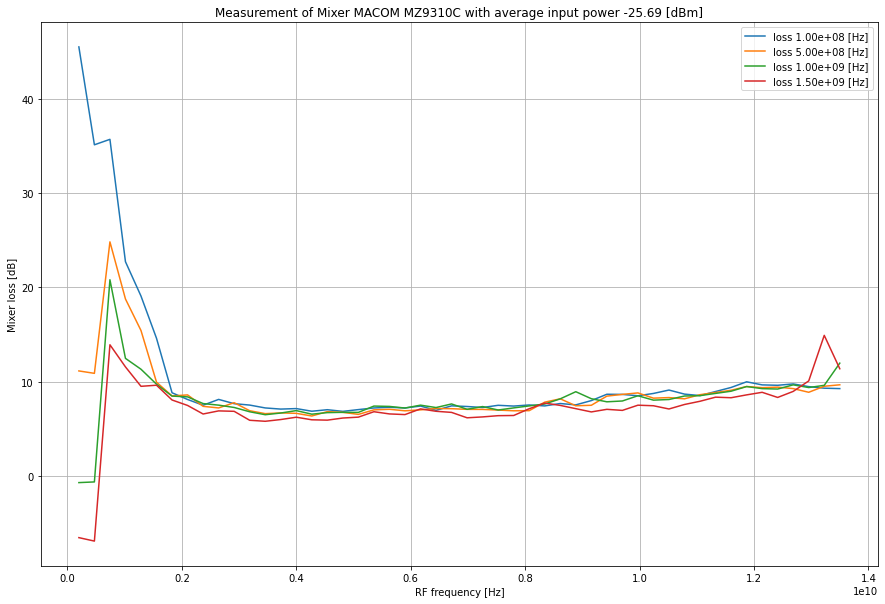

In [37]:
fifs=[100e6, 500e6, 1000e6, 1500e6]
frfs=np.linspace(200e6, 15e9-np.max(fifs), 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C')

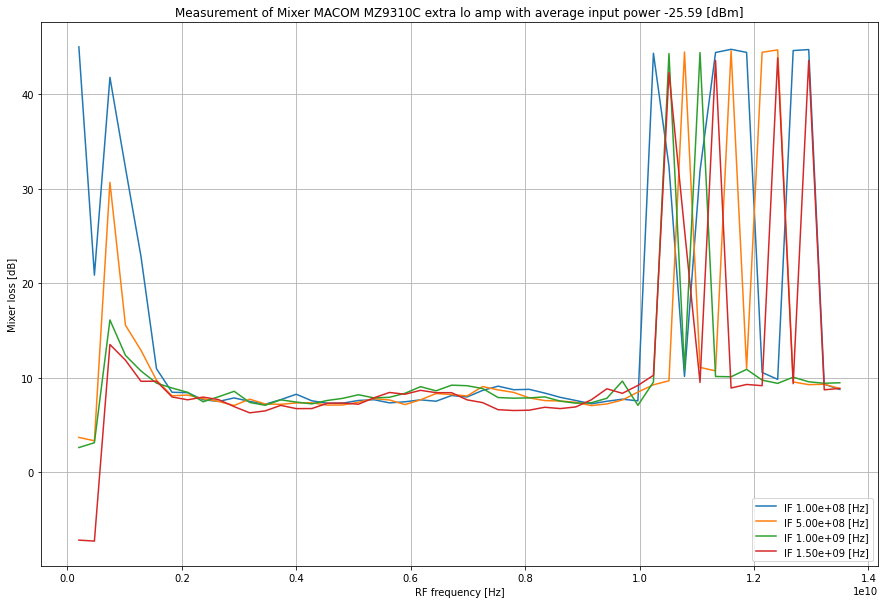

In [19]:
fifs=[100e6, 500e6, 1000e6, 1500e6]
frfs=np.linspace(200e6, 15e9-np.max(fifs), 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C extra lo amp')

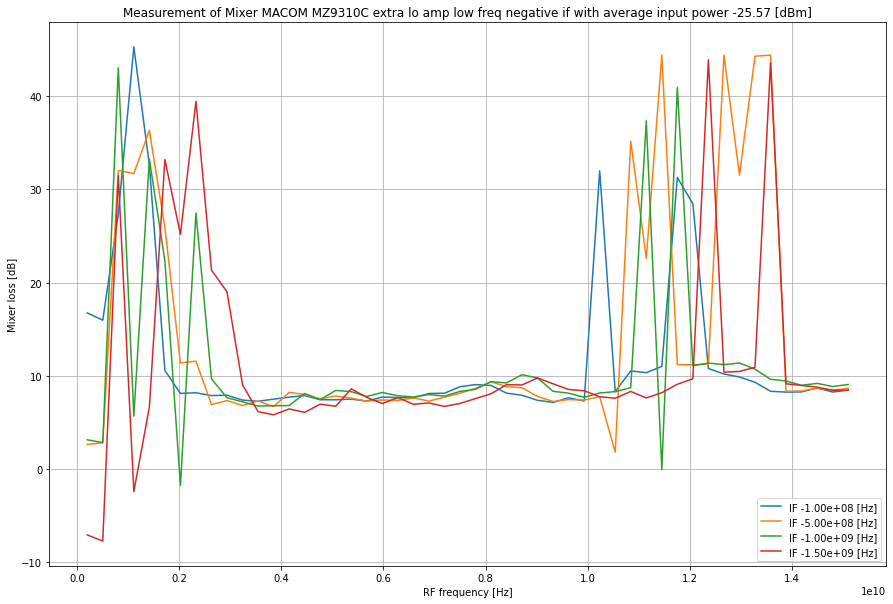

In [27]:
fifs=[-100e6, -500e6, -1000e6, -1500e6]
frfs=np.linspace(200e6, 15e9-np.max(fifs), 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C extra lo amp low freq negative if')

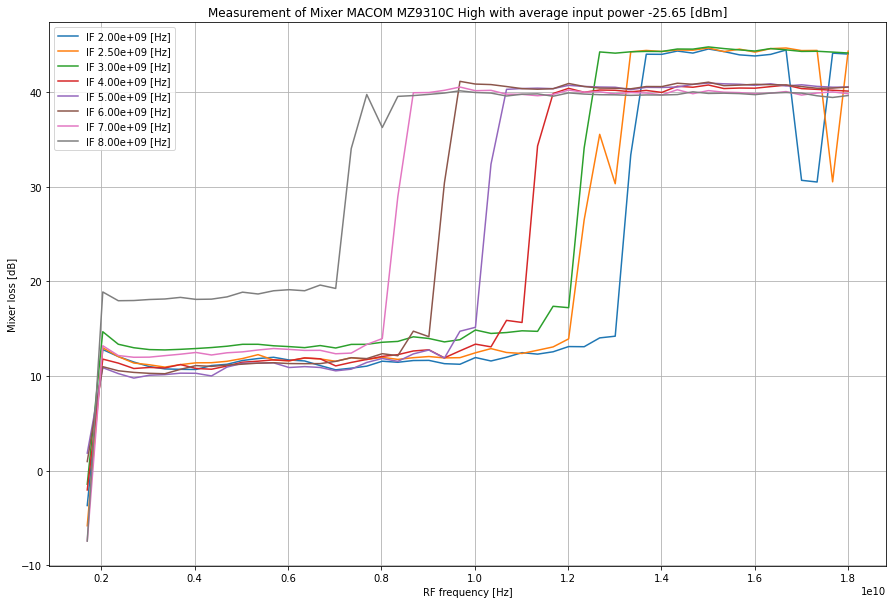

In [15]:
fifs=[2e9, 2.5e9, 3e9, 4e9, 5e9, 6e9, 7e9, 8e9]
frfs=np.linspace(1700e6, 18e9, 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C High', tol=200e6)

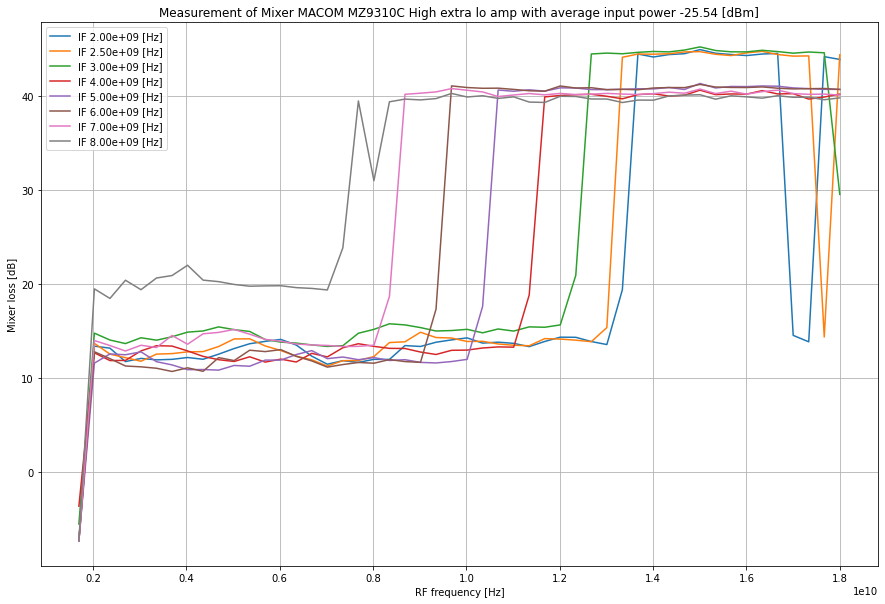

In [40]:
fifs=[2e9, 2.5e9, 3e9, 4e9, 5e9, 6e9, 7e9, 8e9]
frfs=np.linspace(1700e6, 18e9, 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C High extra lo amp', tol=200e6)

In [37]:
fifs=[-2e9, -2.5e9, -3e9, -4e9, -5e9, -6e9, -7e9, -8e9, -9e9]
frfs=np.linspace(1700e6, 24e9, 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C High negative IF', tol=200e6)

KeyboardInterrupt: 

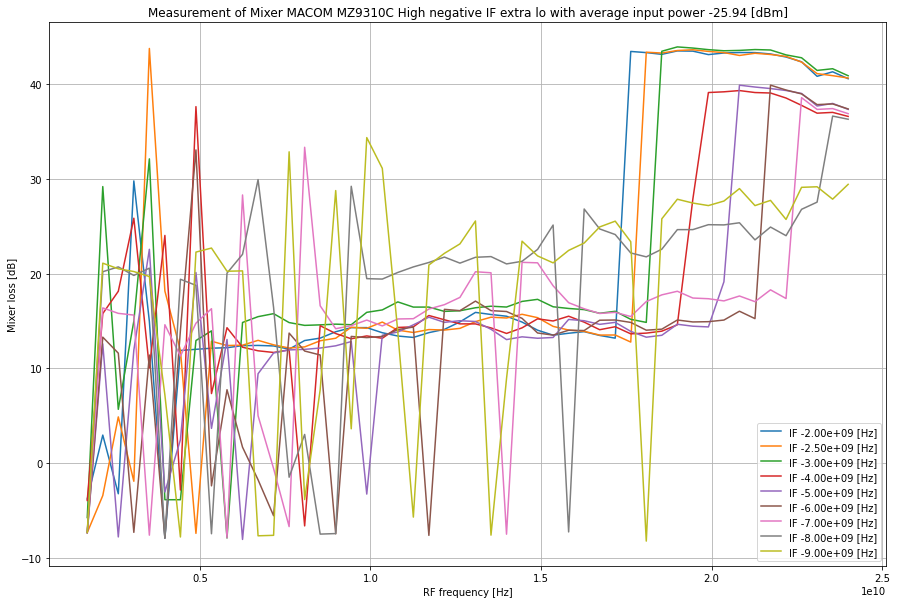

In [39]:
fifs=[-2e9, -2.5e9, -3e9, -4e9, -5e9, -6e9, -7e9, -8e9, -9e9]
frfs=np.linspace(1700e6, 24e9, 50)
mixerCharacterization(fifs, frfs, 'MACOM MZ9310C High negative IF extra lo', tol=200e6)

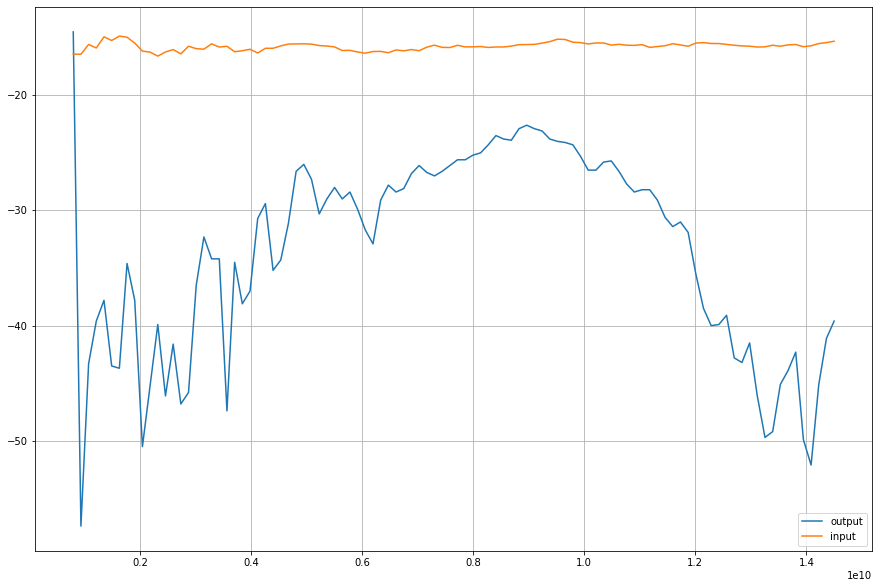

In [58]:
fif=500e6;
dmin=300e6;
fstart=fif+dmin
fstop=15e9-fif;
measureIfFrequency(fif, fstart, fstop, 100)

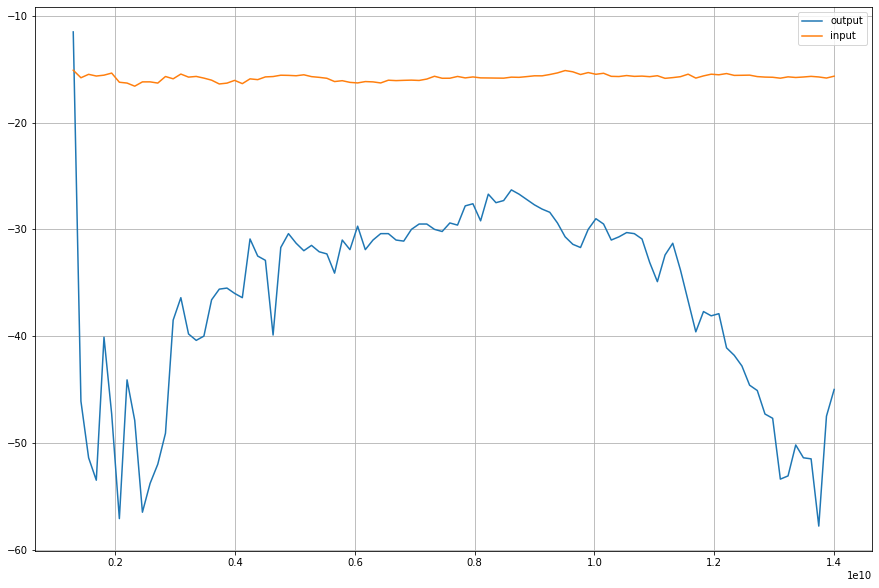

In [59]:
fif=1000e6;
dmin=300e6;
fstart=fif+dmin
fstop=15e9-fif;
measureIfFrequency(fif, fstart, fstop, 100)

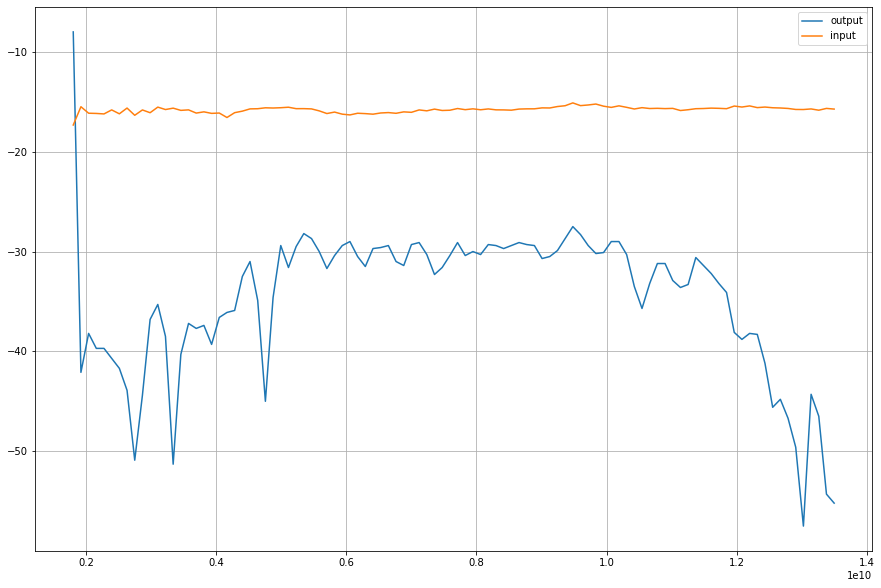

In [60]:
fif=1500e6;
dmin=300e6;
fstart=fif+dmin
fstop=15e9-fif;
measureIfFrequency(fif, fstart, fstop, 100)

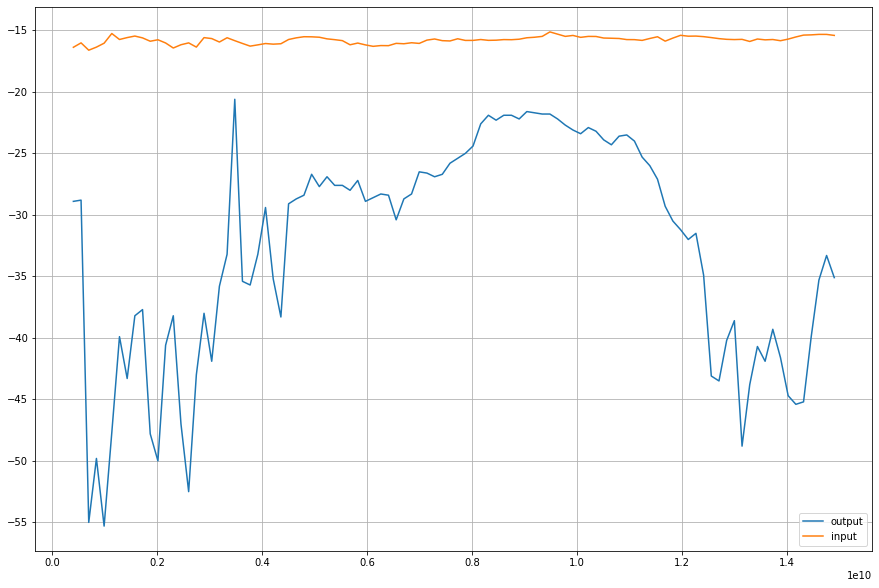

In [61]:
fif=100e6;
dmin=300e6;
fstart=fif+dmin
fstop=15e9-fif;
measureIfFrequency(fif, fstart, fstop, 100)

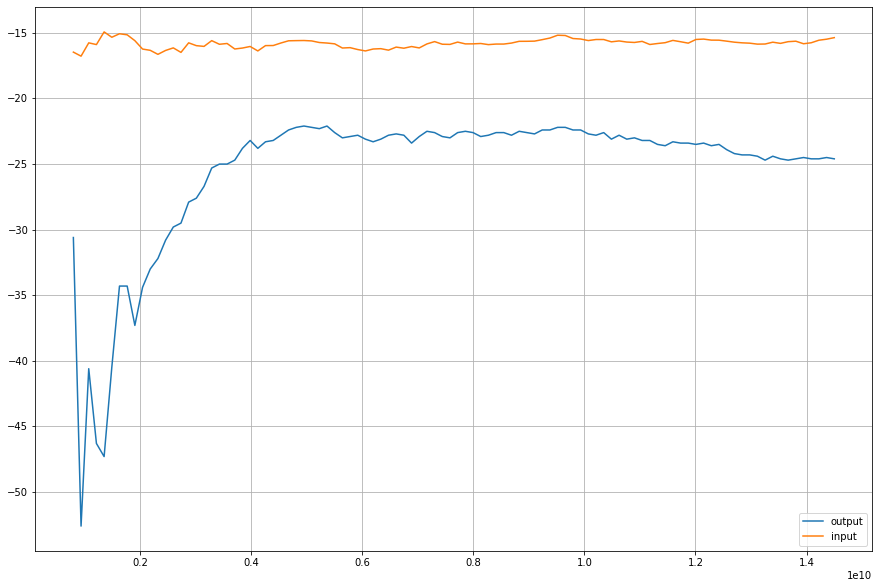

In [62]:
fif=500e6;
dmin=300e6;
fstart=fif+dmin
fstop=15e9-fif;
measureIfFrequency(fif, fstart, fstop, 100)

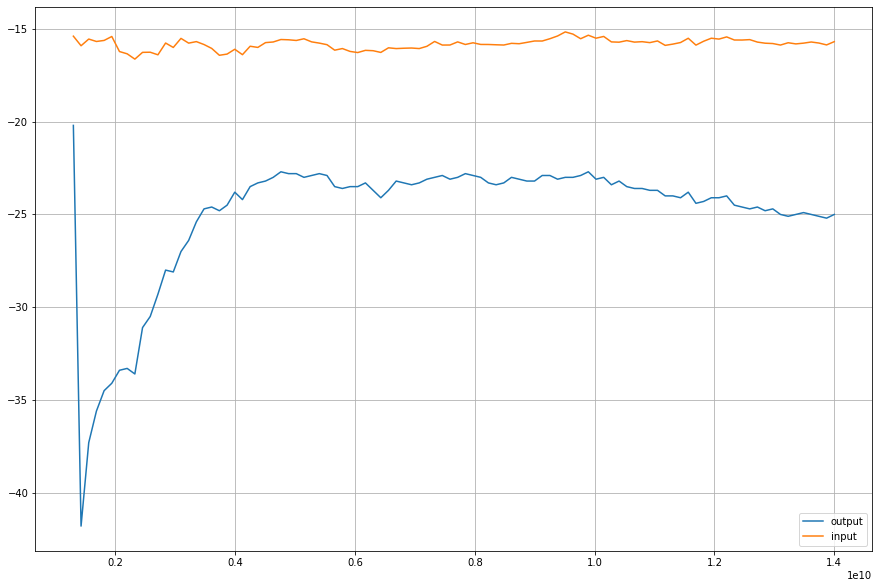

In [63]:
fif=1000e6;
dmin=300e6;
fstart=fif+dmin
fstop=15e9-fif;
measureIfFrequency(fif, fstart, fstop, 100)

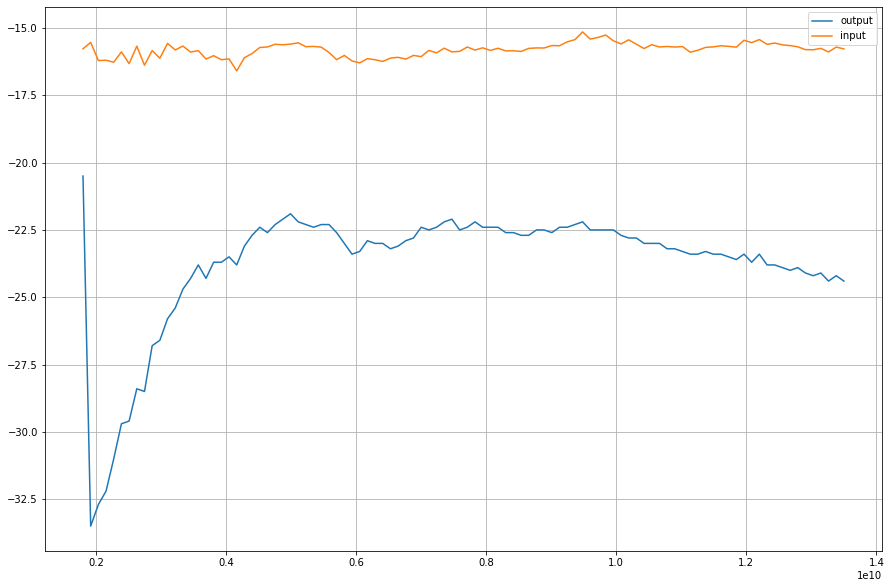

In [64]:
fif=1500e6;
dmin=300e6;
fstart=fif+dmin
fstop=15e9-fif;
measureIfFrequency(fif, fstart, fstop, 100)

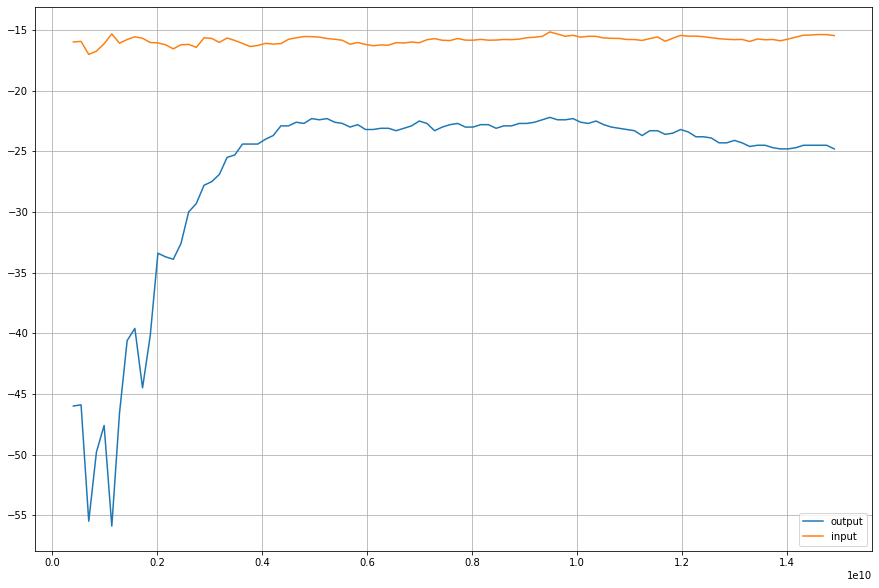

In [65]:
fif=100e6;
dmin=300e6;
fstart=fif+dmin
fstop=15e9-fif;
measureIfFrequency(fif, fstart, fstop, 100)

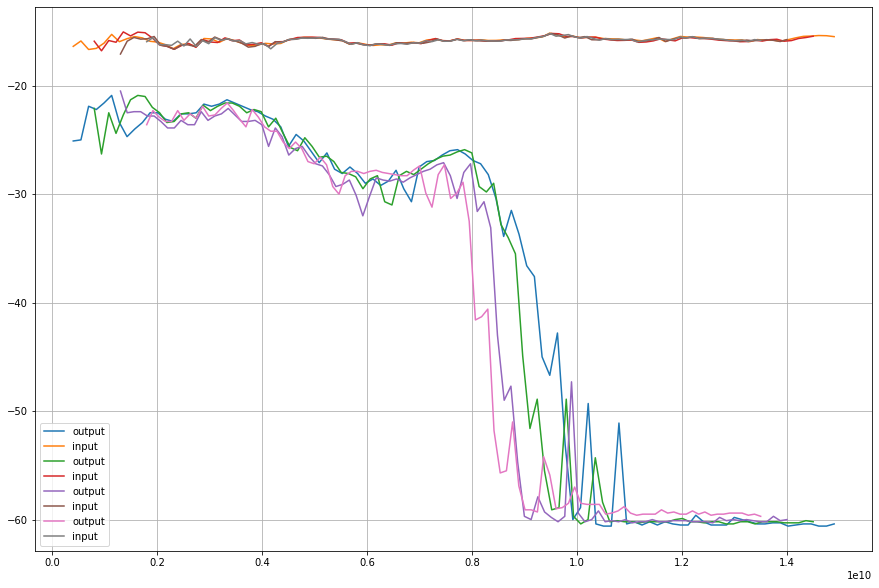

In [66]:
fifs=[100e6, 500e6, 1000e6, 1500e6]
dmin=300e6;
for fif in fifs:
    fstart=fif+dmin
    fstop=15e9-fif;
    measureIfFrequency(fif, fstart, fstop, 100)

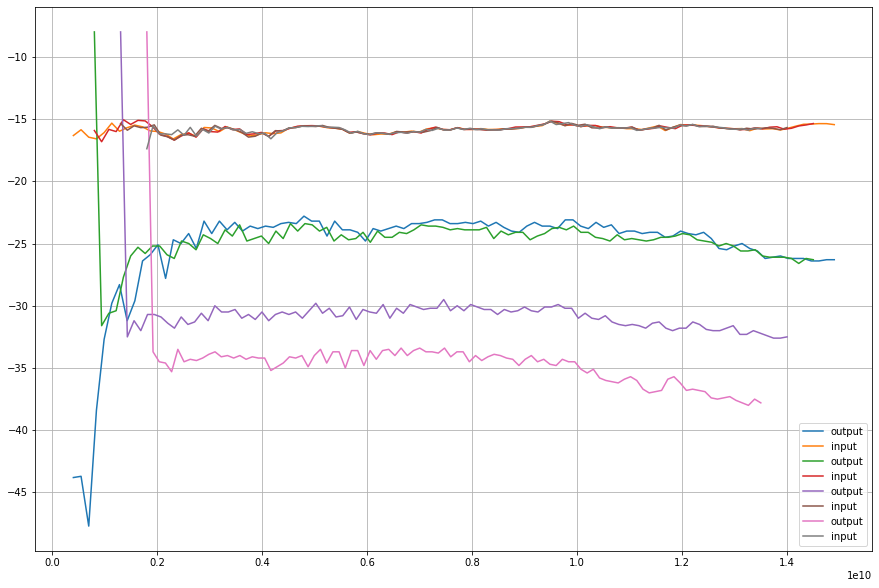

In [67]:
fifs=[100e6, 500e6, 1000e6, 1500e6]
dmin=300e6;
for fif in fifs:
    fstart=fif+dmin
    fstop=15e9-fif;
    measureIfFrequency(fif, fstart, fstop, 100)

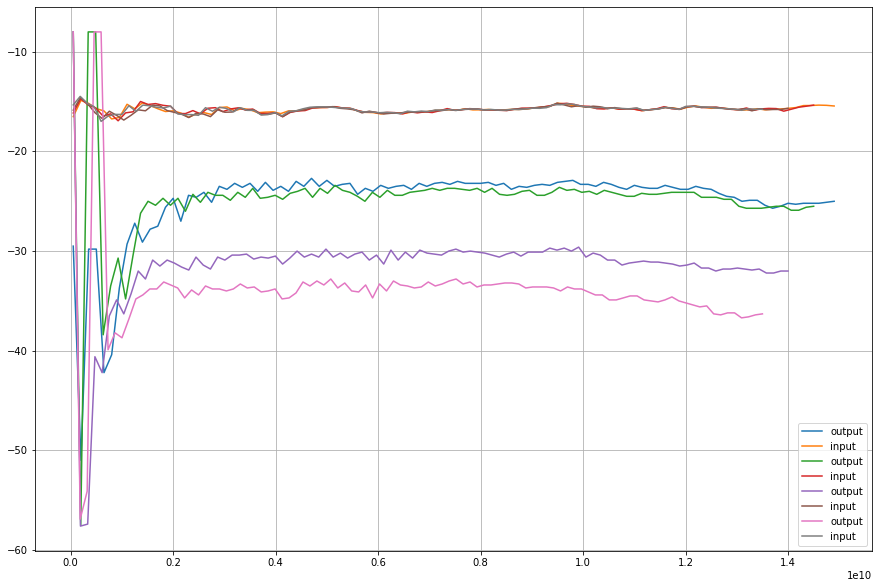

In [69]:
fifs=[100e6, 500e6, 1000e6, 1500e6]
dmin=300e6;
for fif in fifs:
    fstart=50e6#fif+dmin
    fstop=15e9-fif;
    measureIfFrequency(fif, fstart, fstop, 100)

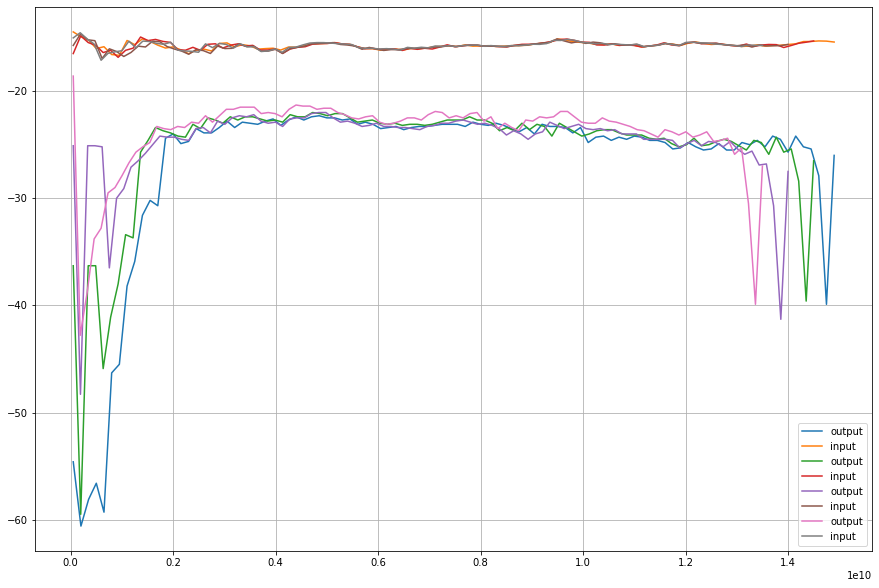

In [6]:
fifs=[100e6, 500e6, 1000e6, 1500e6]
dmin=300e6;
for fif in fifs:
    fstart=50e6#fif+dmin
    fstop=15e9-fif;
    measureIfFrequency(fif, fstart, fstop, 100)

8048280000.0 2.122668
Actual lo 23048279999.98077 requested 23048280000.0
2.121506
[]


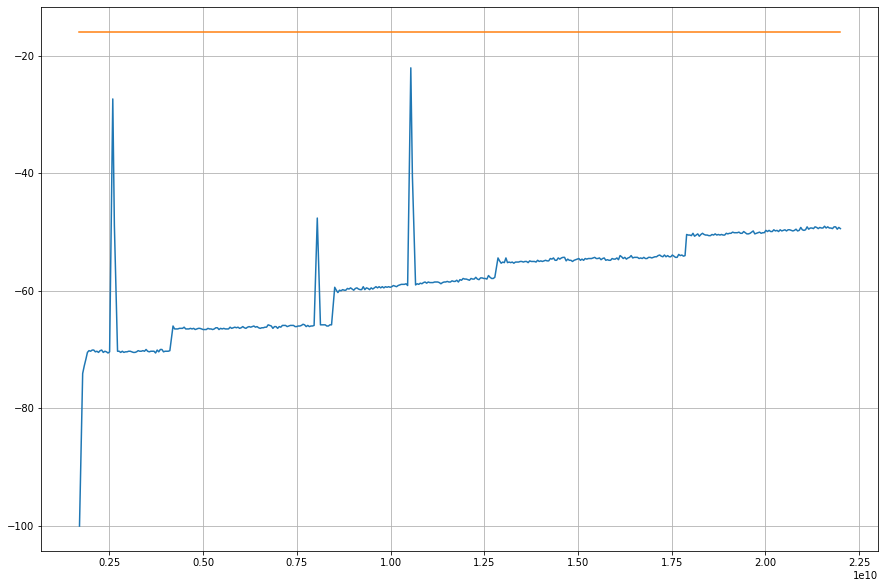

In [41]:
#counter.clear()
counter.ifc()
gen.setCwFreq(10e9)
time.sleep(0.5)
gen.setCwFreq(8e9)

gen.setLevel(10)
waitForFrequencyToStablizie()

f=counter.readValue()
l=pm.readChannelB(f)
print(f, l)
flo=f+15000e6
fact, fvco, n = lmx.setFrequency(flo)
print("Actual lo", fact, "requested", flo)
print(pm.readChannelB(counter.readValue()))
fax, po=sp.readTrace()
#print(fax)
plt.plot(fax, po)
plt.plot([fax[0], fax[-1]], [l-18, l-18])
plt.grid(True)
print(fax[np.where(np.logical_and(fax>1600e6, fax < 1700e6))])

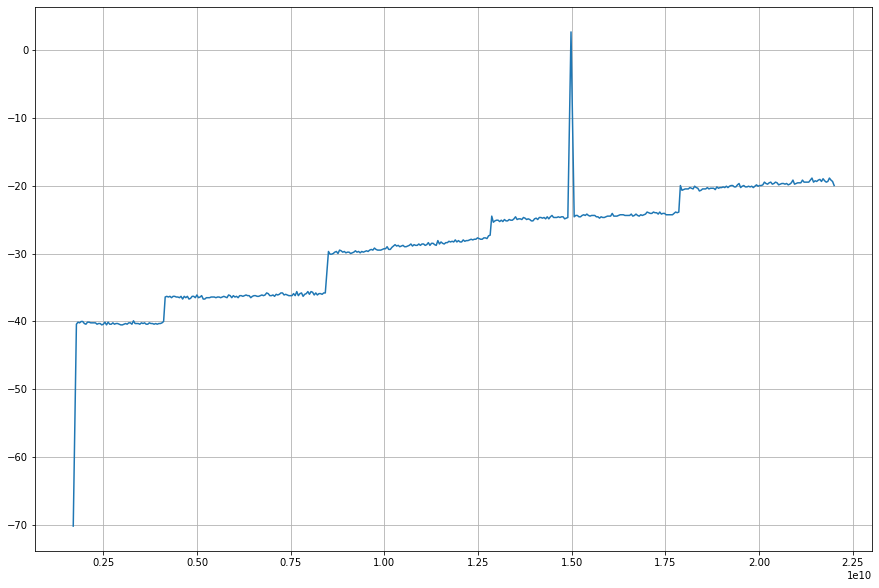

In [17]:
lmx.setFrequency(15e9)
sp.updateTrace()
fax, po=sp.readTrace()
plt.plot(fax, po)
plt.grid(True)